In [18]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
import os
import numpy as np
import pandas as pd
import scipy

from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [2]:
import os
#data_file_path = os.path.join(os.path.dirname(__file__), "YX.csv")
data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")
#data_file_path = os.path.join(os.getcwd(), "Compustat.csv")

In [3]:
import pandas as pd
RData = pd.read_csv(data_file_path)
finalData=RData
finalData


# finalData = dataset.map(..., num_parallel_calls=10)
# finalData = dataset.prefetch(buffer_size)

,gvkey,returns,MktCap,actq,ancq,aoq,apq,atq,ceqq,cheq,...,loc,city,naics,acctstdq,bsprq,compstq,scfq,staltq,fdateYQ,Split
0,1166,5.790906,6.982496e+08,449.2100,226.4910,98.5010,46.8590,675.7010,269.458,132.7710,...,NLD,Almere,333242,DI,GO,NaN,4,NaN,2009.50,Train
1,1166,23.806025,7.386845e+08,477.9990,182.7940,65.3570,65.7890,660.7930,224.728,147.6530,...,NLD,Almere,333242,US,GO,NaN,4,NaN,2009.75,Train
2,1166,16.083086,9.145360e+08,648.3670,203.3330,88.5220,93.1170,851.7000,241.229,293.9020,...,NLD,Almere,333242,US,GO,NaN,4,NaN,2010.00,Train
3,1166,2.147239,1.061622e+09,688.7330,217.9080,90.3310,103.6170,906.6410,267.154,279.0030,...,NLD,Almere,333242,US,GO,AC,4,NaN,2010.25,Train
4,1166,-9.884885,1.084417e+09,817.5550,274.2700,121.3910,130.4130,1091.8250,384.873,308.2200,...,NLD,Almere,333242,DI,GO,AC,4,NaN,2010.50,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219435,354202,-30.455373,8.152214e+09,1373.5955,401.5331,107.8755,369.7450,1775.1286,1160.355,754.8797,...,CHN,Dongguan,334511,DS,GO,NaN,4,NaN,2022.50,Test
219436,354264,-3.332285,1.043118e+10,487.6897,314.6730,172.0490,16.8126,802.3627,619.938,324.9903,...,CHN,Shanghai,325414,DS,GO,NaN,4,NaN,2022.50,Test
219437,354265,-5.087739,1.493539e+11,7093.8807,3513.1771,1364.9773,1373.2159,10607.0579,5347.721,2451.6048,...,CHN,Shanghai,334510,DS,GO,NaN,4,NaN,2022.50,Test
219438,354276,14.705208,NaN,9830.0525,1906.2135,959.3752,461.3957,11736.2660,9411.389,7817.0480,...,CHN,Shenzhen,339112,ND,GO,NaN,4,NaN,2022.50,Test


In [4]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
finalData.dtypes


# testDF = pd.DataFrame({
#     "A": [1, 2],
#     "B": [6, 7]
# }
# )


gvkey         int64
returns     float64
MktCap      float64
actq        float64
ancq        float64
aoq         float64
apq         float64
atq         float64
ceqq        float64
cheq        float64
cstkq       float64
eqrtq       float64
ibmiiq      float64
ibq         float64
lcoq        float64
lcoxq       float64
lctq        float64
loq         float64
lseq        float64
ltmibq      float64
ltq         float64
piq         float64
ppentq      float64
rectq       float64
revtq       float64
sctq        float64
seqq        float64
loc          object
city         object
naics         int64
acctstdq     object
bsprq        object
compstq      object
scfq          int64
staltq      float64
fdateYQ     float64
Split        object
dtype: object

In [22]:
# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX

import numpy as np


factorCols = ["gvkey", "datacqtr", "sic", "naics", "loc", "idbflag",
              "gsubind", "ggroup", "gind", "gsector",
              "fic", "city", "fyrc",
              "curcdq", "exchg", "Split"]

finalData[factorCols] = finalData[factorCols].astype("str")


nonNumCols = ["returns", "MktCap", "fdateq", "datacqtr", "datadate"] + factorCols
numCols     = finalData.columns.difference(nonNumCols)


finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
finalData["datadate"] = pd.to_datetime(finalData["datadate"], format = "%Y%m%d")
# #finalData["fdateq"] = pd.to_datetime(finalData["datacqtr"], format = "%Y%q") #check quarter format


#Currently not grouped by quarter
finalData = finalData.sort_values(by=['datacqtr', "fdateq"])

trainSize = round(len(finalData.index)*0.4)
validationSize = round(len(finalData.index)*0.7)




Y = finalData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]

X = finalData.loc[:, finalData.columns != "returns"]



X = X.select_dtypes(include=[np.number])
#X = X.dropna()





In [23]:
#X.dtypes

#finalData.info(verbose=True)
finalData[numCols].info(verbose=True)
#finalData.dtypes
#print(finalData.dtypes)
#finalData.columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57116 entries, 5086 to 40105
Data columns (total 85 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   accdq     57116 non-null  float64
 1   acoq      57116 non-null  float64
 2   acoxq     57116 non-null  float64
 3   actq      57116 non-null  float64
 4   ancq      57116 non-null  float64
 5   aoq       57116 non-null  float64
 6   apq       57116 non-null  float64
 7   atq       57116 non-null  float64
 8   capsq     57116 non-null  float64
 9   capxy     57116 non-null  float64
 10  ceqq      57116 non-null  float64
 11  chechy    57116 non-null  float64
 12  cheq      57116 non-null  float64
 13  cogsq     57116 non-null  float64
 14  cogsy     57116 non-null  float64
 15  cstkq     57116 non-null  float64
 16  dfxaq     57116 non-null  float64
 17  dfxay     57116 non-null  float64
 18  dlcq      57116 non-null  float64
 19  dlttq     57116 non-null  float64
 20  dpcy      57116 non-null 

In [24]:
#Ratio data
#xRatioData = finalData.apply(lambda x: x/finalData["revtq"])
xRatioData = finalData

xRatioData[numCols] = finalData[numCols].div(finalData["MktCap"].values, axis=0)
#xRatioData = X.div(finalData["MktCap"].values, axis=0)
#xRatioData = xRatioData.loc[:, xRatioData.columns != "MktCap"]


#xRatioData = xRatioData.dropna()
xRatioData


,returns,MktCap,gvkey,fdateq,datadate,datacqtr,curcdq,accdq,acoq,acoxq,...,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic,Split
5086,15.062762,2.397360e+09,201336,2009-11-30,2010-02-03,2009.5,ARS,1.495808e-07,4.996121e-08,3.867379e-08,...,6,3020,302020,30,30202010,B,ARG,999977,9997,Train
3967,15.425532,7.305680e+09,200144,2009-12-19,2010-02-03,2009.5,ARS,1.953666e-08,3.615748e-09,2.146987e-09,...,6,1510,151040,15,15104010,I,ARG,331313,3334,Train
33538,-7.738095,3.598494e+08,278800,2010-01-23,2010-02-03,2009.5,ARS,7.727150e-08,9.710952e-08,9.609604e-08,...,12,3020,302020,30,30202030,I,ARG,3114,2030,Train
11593,18.545366,1.272073e+09,210918,2010-03-19,2010-05-03,2009.5,EUR,2.767136e-08,2.224715e-08,1.226344e-08,...,6,3020,302020,30,30202010,I,FRA,111422,100,Train
36061,-22.125000,1.059303e+08,282729,2010-03-21,2010-05-03,2009.5,EUR,3.382979e-07,8.050577e-08,8.050577e-08,...,6,5020,502020,50,50202010,I,FRA,711211,7941,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39597,0.000000,1.524995e+08,288572,2022-06-08,2022-08-03,2022.0,PLN,1.075531e-06,1.257119e-07,1.257119e-07,...,12,2010,201030,20,20103010,I,POL,237,1600,Test
8334,0.000000,2.370305e+12,204867,2022-06-11,2022-08-03,2022.0,INR,5.265273e-08,2.802467e-08,2.134241e-08,...,3,4510,451020,45,45102010,B,IND,541512,7373,Test
46649,0.000000,1.393536e+09,297105,2022-06-13,2022-08-03,2022.0,TWD,8.316973e-08,5.913446e-08,9.864834e-09,...,12,3510,351010,35,35101020,I,TWN,334510,3845,Test
50126,0.000000,1.562824e+09,313975,2022-06-13,2022-08-03,2022.0,PLN,5.151891e-08,9.112075e-07,9.112075e-07,...,12,5510,551010,55,55101010,I,POL,2211,4911,Test


In [25]:
#Winsorised data
import scipy


# XArray = np.asarray(xRatioData).astype('float32')
# # numberOfVariables = XArray.shape[1]

# xWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.01, 0.01))
# #yWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.01, 0.01))


xWinData=xRatioData

xWinData[numCols] = xRatioData[numCols].apply(lambda x: scipy.stats.mstats.winsorize(x, limits = (0.01, 0.01)))


In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

# scaled_X = scaler.fit_transform(XArray)
# #scaled_X = np.apply_along_axis(func1d=scaler.fit_transform, axis=1, arr=X) #Why over rows??? prob axis=0 instead

# xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]

# scaled_winX = scaler.fit_transform(xWinData)
# xWinTrain, xWinVal, xWinTest = scaled_winX[:trainSize,:], scaled_winX[trainSize:validationSize,:], scaled_winX[validationSize:, :]


xScaledData=xWinData
#xScaledData[numCols] = xScaledData[numCols].apply(lambda x: scaler.fit_transform(x))
xScaledData[numCols] = scaler.fit_transform(xScaledData[numCols])





#scaled_X = scaled_X.apply(lambda x : x.reshape(-1, 1))
# droppedCols = ["ajexdi", "prccd", "trfd"]
# trainX.drop(droppedCols, axis=1, inplace=True)
# trainX['gvkey'] = trainX['gvkey'].astype(object)
# trainX['gvkey'] = trainX['gvkey'].astype(object)

#trainX.dtypes

In [27]:
ScaledWinsRatioPath = os.path.join(os.getcwd(), "Data\ScaledWinsRatioData.csv")


# XOutputDF = pd.DataFrame(scaled_winX)
# YOutputDF = pd.DataFrame(Y)

# NNReadyDataWithLabels = XOutputDF.append(finalData["fdateq"], finalData["datadate"], finalData["datacqtr"], YOutputDF)

#np.savetxt(ScaledWinsRatioPath, xScaledData, delimiter=",")
pd.DataFrame(xScaledData).to_csv(ScaledWinsRatioPath, index=False)


In [28]:
# data_file_path = os.path.join(os.getcwd(), "Data\YXWithSplit.csv")
# splittedData = pd.read_csv(data_file_path)

# #Currently not grouped by quarter
# splittedData = splittedData.sort_values(by=['datacqtr', "fdateq"])


# # trainSize = round(len(xScaledData.columns)*0.4)
# # validationSize = round(len(xScaledData.columns)*0.7)


split = xScaledData["Split"]
# xWinTrain, xWinVal, xWinTest = splittedData.loc[split=="Train", :], splittedData.loc[split=="Validation", :], splittedData.loc[split=="Test", :]


Y = xScaledData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[split=="Train"], Y[split=="Validation"], Y[split=="Test"]




np.asarray(Y)
yTrain, yVal, yTest = Y[split=="Train"], Y[split=="Validation"], Y[split=="Test"]

X = xScaledData.drop(["returns", "MktCap"], axis=1)
X = X.select_dtypes(include=[np.number])
xWinTrain, xWinVal, xWinTest = X.loc[split=="Train", :], X.loc[split=="Validation", :], X.loc[split=="Test", :]



# xWinTrain, xWinVal, xWinTest = X[:trainSize, :], X[trainSize:validationSize, :], X[validationSize:, :]

In [29]:
# scaledWinsRatioPathWithSplit = os.path.join(os.getcwd(), "Data\ScaledWinsRatioDataWithSplit.csv")
# pd.DataFrame(xScaledData).to_csv(scaledWinsRatioPathWithSplit, index=False)


In [30]:

# groupedY = Y.groupby(["state", "gender"])["last_name"].count()
# yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]



# groupedX = scaled_X.groupby(["state", "gender"])["last_name"].count()
# xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]




In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [32]:
# model = Sequential([
#     Dense(units=16,  activation='relu'), #input_shape=(, 10, numberOfVariables),
#     Dense(units=32, activation='relu'),
#     Dense(units=1)
# ])


In [33]:
# model = tf.keras.Sequential()

# model.add(Dense(units=10,  activation='relu'))
# model.add(tf.keras.layers.Dropout(.5))
# model.add(Dense(units=10, activation='relu'))
# model.add(Dense(units=1))

In [34]:
# model.compile(optimizer="sgd",  # Adam(learning_rate=0.0001),
#               loss="MeanSquaredError", #'tf.keras.losses.MeanSquaredError()',
#               metrics=['accuracy'])

In [35]:
# model.fit(x=xTrain, y=yTrain,
#           batch_size=10, epochs=30, verbose=2)


In [36]:
# loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)

# model.predict(xVal, batch_size=128)

In [37]:
def NNfunction(modelType, layers, hidUnits, actvFunc, dropout, L1, L2):
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    #callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")


    model = tf.keras.Sequential()

    if modelType == "LSTM":
        model.add(tf.keras.layers.LSTM(units=hidUnits, input_shape=(2,)))
    elif modelType == "GRU":
        model.add(tf.keras.layers.GRU(units=hidUnits))
    elif modelType == "SimpleRNN":
        # keras.layers.SimpleRNN(1, input_shape=[None, 1])
        model.add(tf.keras.layers.SimpleRNN(units=hidUnits))
    elif modelType == "Linear":
        model.add(Dense(units=1,
                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
    elif modelType == "NaiveForecast":
        model.add(Dense(units=1, 
                        kernel_constraint = tf.keras.constraints.MinMaxNorm(
                            min_value=0, 
                            max_value=0, 
                            rate=1.0, 
                            axis=0)))
    else:
        try:
            for n in range(0, layers):
                model.add(Dense(units=hidUnits,
                                activation=actvFunc,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
                model.add(tf.keras.layers.Dropout(dropout))
                # scaler.fit_transform
                # tf.keras.layers.BatchNormalization(
        except:
            model.add(Dense(units=hidUnits, activation=actvFunc,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
            model.add(tf.keras.layers.Dropout(dropout))

            
        model.add(Dense(units=1))



    model.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                  loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()'  #Huber   #MeanAbsoluteError
                  metrics=["MeanAbsoluteError"]) #accuracy




    # model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)
    


    history = model.fit(x=xWinTrain, y=yTrain,
              batch_size=32, epochs=300,
              callbacks=[callback], verbose=2, validation_data = (xWinVal, yVal))

    loss_and_metrics = model.evaluate(xWinVal, yVal, batch_size=32)
    
    epochs_EarlyStopping = len(history.history['loss'])
    #history.history[]




    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    
    
    try:
        loss_and_metrics = [x for x in loss_and_metrics]
    except:     
        print(loss_and_metrics)

    return loss_and_metrics, model, epochs_EarlyStopping

    #model.predict(xVal, batch_size=128)

    





In [5]:
#Hyper-Parameters
NNModelType = {"Forward"} #, "LSTM", "GRU"}
hiddenLayers = {2, 3, 4, 5}
hiddenUnits = {2, 3, 4, 5, 10}
activationFunc = {"relu", "sigmoid", "tanh"} #etc. https://keras.io/api/layers/activations/
dropOut = {0.5, 0.2, 0}
#epochs = [100] #Just choose best model. => Run for 100 epochs, but if 20th epoch is the best, choose it, i.e. early stopping
#inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = {8, 16, 32, 64}
optim = {"RMSprop", "Adam", "sgd"}


none = {"NA"}

L1L2Grid = 10**np.linspace(start=3, stop=-5, num=6) #3 and -10
L1L2Grid = set(np.append(L1L2Grid, 0))


NNParams = {"Model type": NNModelType,  # , "LSTM", "GRU"},
            "Hidden layers": hiddenLayers,
            "Hidden units": hiddenUnits,
            "Activation function": activationFunc,
            "Dropout": dropOut,
            "L1": L1L2Grid,
            "L2": L1L2Grid
            }

LinearParams = {"Model type": {"Linear"},
               "Hidden layers": none,
               "Hidden units": none,
               "Activation function": none,
               "Dropout": none,
               "L1": L1L2Grid,
               "L2": L1L2Grid
               }

NaiveParams = {"Model type": {"NaiveForecast"},
               "Hidden layers": none,
               "Hidden units": none,
               "Activation function": none,
               "Dropout": none,
               "L1": none,
               "L2": none
               }


import itertools
import pandas as pd
NNGrid = pd.DataFrame(itertools.product(
    *NNParams.values()), columns=NNParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())

NaiveGrid = pd.DataFrame(itertools.product(
    *NaiveParams.values()), columns=NaiveParams.keys())


#Random grid search
#import random
#random.seed(2302)
randomNNGrid = NNGrid.sample(n=32)

HPGrid = pd.concat([linearGrid, randomNNGrid, NaiveGrid])


# hyperParams = np.concatenate((LinearParams, NNParams, RNNParams))
#hyperParams = np.concatenate(grid, LinearParams)



In [39]:
MSEMatrix = pd.DataFrame()
pd.options.mode.chained_assignment = None


#validationSize = 2 #length(validXPools)
#HPsize = len(hyperParams.index)
HPsize = np.shape(HPGrid)[0]
#HPsize = 2   #176 models took 40 min

for n in range(0, HPsize):
  print("\n")
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]
  CV = NNfunction(*HP)

  #a = pd.DataFrame([CV])
  newMSE = HPGrid.iloc[[n]]

  MSE = CV[0][0]
  MAE = CV[0][1]
  Epochs = CV[2]
  ModelPointer = CV[1]

  # newMSE['MSE'] = MSE
  # newMSE['MAE'] = MAE

  newMSE.loc[:,"Epochs"] = Epochs
  newMSE.loc[:,"MSE"] = MSE
  newMSE.loc[:,"MAE"] = MAE
  newMSE.loc[:,"ModelPointer"] = ModelPointer

  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)
  
  # newMSE = a.join(b)
  # newMSE2 = pd.concat([b, a])
  #newMSE = pd.concat([b, a], axis=1, ignore_index=True, sort=False)
  #newMSE =  pd.concat(HPGrid.iloc[[n]], CV)
  #newMSE = np.concatenate((HP, CV))
  #MSEMatrix = np.concatenate((MSEMatrix, newMSE))
  #MSEMatrix = pd.concat(MSEMatrix, newMSE)
  #MSEMatrix = pd.concat([MSEMatrix, [HP, CV]])

finalResults = MSEMatrix

#finalResults[:,-1] = apply(finalResults[,-1], MARGIN=2, FUN=as.numeric)
#finalResults = finalResults[order(finalResults[,"MSE"]),]
#finalResults <- apply(finalResults, 2, as.character)

#write.csv2(finalResults, "results3.csv", row.names = FALSE)


#pd.DataFrame.to_csv(MSEMatrix, "resultsPython.csv")


#finalResults = finalResults[order(finalResults[,"MSE"]),]

formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix




Model  1  out of  48
Epoch 1/300
304/304 - 3s - loss: 8978.4863 - mean_absolute_error: 25.8724 - val_loss: 2027.2751 - val_mean_absolute_error: 20.3336 - 3s/epoch - 10ms/step
Epoch 2/300
304/304 - 2s - loss: 5329.3408 - mean_absolute_error: 25.8738 - val_loss: 2034.1644 - val_mean_absolute_error: 20.3555 - 2s/epoch - 5ms/step
Epoch 3/300
304/304 - 2s - loss: 5324.3418 - mean_absolute_error: 25.8776 - val_loss: 2023.2325 - val_mean_absolute_error: 20.3802 - 2s/epoch - 6ms/step
Epoch 4/300
304/304 - 2s - loss: 5320.0464 - mean_absolute_error: 25.8836 - val_loss: 2030.2850 - val_mean_absolute_error: 20.4056 - 2s/epoch - 6ms/step
Epoch 5/300
304/304 - 2s - loss: 5315.3223 - mean_absolute_error: 25.8905 - val_loss: 2026.7729 - val_mean_absolute_error: 20.4326 - 2s/epoch - 6ms/step
Epoch 6/300
304/304 - 2s - loss: 5311.2344 - mean_absolute_error: 25.8999 - val_loss: 2025.4153 - val_mean_absolute_error: 20.4599 - 2s/epoch - 5ms/step
Epoch 7/300
304/304 - 2s - loss: 5307.3906 - mean_absolute

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
5,Linear,NA,NA,NA,NA,0.00000,0.00000,21,1976.417969,20.840441,<keras.engine.sequential.Sequential object at ...
15,Linear,NA,NA,NA,NA,0.00001,0.00001,21,1976.797974,20.883568,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,21,1976.874390,20.708130,<keras.engine.sequential.Sequential object at ...
13,Linear,NA,NA,NA,NA,0.00001,0.00000,21,1977.610352,20.894789,<keras.engine.sequential.Sequential object at ...
11,Linear,NA,NA,NA,NA,0.10000,0.00001,21,1978.101562,20.826056,<keras.engine.sequential.Sequential object at ...
6,Linear,NA,NA,NA,NA,0.00000,0.10000,21,1978.105347,20.883444,<keras.engine.sequential.Sequential object at ...
9,Linear,NA,NA,NA,NA,0.10000,0.00000,21,1978.509155,20.915751,<keras.engine.sequential.Sequential object at ...
14,Linear,NA,NA,NA,NA,0.00001,0.10000,21,1979.515381,21.058056,<keras.engine.sequential.Sequential object at ...
2119,Forward,4,10,relu,0.5,0.00000,0.00001,24,1979.703491,20.767260,<keras.engine.sequential.Sequential object at ...
10,Linear,NA,NA,NA,NA,0.10000,0.10000,21,1981.033447,20.988796,<keras.engine.sequential.Sequential object at ...


In [40]:
formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
5,Linear,NA,NA,NA,NA,0.00000,0.00000,21,1976.417969,20.840441,<keras.engine.sequential.Sequential object at ...
15,Linear,NA,NA,NA,NA,0.00001,0.00001,21,1976.797974,20.883568,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,21,1976.874390,20.708130,<keras.engine.sequential.Sequential object at ...
13,Linear,NA,NA,NA,NA,0.00001,0.00000,21,1977.610352,20.894789,<keras.engine.sequential.Sequential object at ...
11,Linear,NA,NA,NA,NA,0.10000,0.00001,21,1978.101562,20.826056,<keras.engine.sequential.Sequential object at ...
6,Linear,NA,NA,NA,NA,0.00000,0.10000,21,1978.105347,20.883444,<keras.engine.sequential.Sequential object at ...
9,Linear,NA,NA,NA,NA,0.10000,0.00000,21,1978.509155,20.915751,<keras.engine.sequential.Sequential object at ...
14,Linear,NA,NA,NA,NA,0.00001,0.10000,21,1979.515381,21.058056,<keras.engine.sequential.Sequential object at ...
2119,Forward,4,10,relu,0.5,0.00000,0.00001,24,1979.703491,20.767260,<keras.engine.sequential.Sequential object at ...
10,Linear,NA,NA,NA,NA,0.10000,0.10000,21,1981.033447,20.988796,<keras.engine.sequential.Sequential object at ...


In [44]:
#MSEMatrix

finalResults = finalResults.reset_index()
index = finalResults['MSE'].idxmin()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]



# xTrainValiPooled = scaled_X[:validationSize,:]
# yTrainValiPooled = Y[:validationSize]

#xTrainValiPooled = scaled_X[:validationSize,:]
xTrainValiPooled = X.loc[split!="Test", :]
#yTrainValiPooled = Y[:validationSize]
yTrainValiPooled = Y[split!="Test"]

#bestModel = bestParams["ModelPointer"]
bestModel = finalResults.iloc[index]["ModelPointer"]

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled,
                        batch_size=32, epochs=100,
                        callbacks=[callback], verbose=2, validation_split=0.5)

bestModel.save('Results/BestKerasModel8')



Epoch 1/100
490/490 - 2s - loss: 4428.0776 - mean_absolute_error: 25.3304 - val_loss: 1526.6937 - val_mean_absolute_error: 21.4128 - 2s/epoch - 5ms/step
Epoch 2/100
490/490 - 2s - loss: 4423.8120 - mean_absolute_error: 25.5821 - val_loss: 1530.6823 - val_mean_absolute_error: 21.5538 - 2s/epoch - 4ms/step
Epoch 3/100
490/490 - 2s - loss: 4423.3311 - mean_absolute_error: 25.5494 - val_loss: 1534.4807 - val_mean_absolute_error: 21.6937 - 2s/epoch - 3ms/step
Epoch 4/100
490/490 - 2s - loss: 4421.7847 - mean_absolute_error: 25.6791 - val_loss: 1535.7168 - val_mean_absolute_error: 21.7303 - 2s/epoch - 4ms/step
Epoch 5/100
490/490 - 2s - loss: 4421.3647 - mean_absolute_error: 25.6626 - val_loss: 1537.8798 - val_mean_absolute_error: 21.8041 - 2s/epoch - 5ms/step
Epoch 6/100
490/490 - 2s - loss: 4420.2402 - mean_absolute_error: 25.7311 - val_loss: 1538.1147 - val_mean_absolute_error: 21.8051 - 2s/epoch - 3ms/step
Epoch 7/100
Restoring model weights from the end of the best epoch: 1.
490/490 - 2

In [42]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [45]:
formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)
formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["MSE"], axis = 0)
#formattedMSEMatrix[["L1", "L2"]] = round(formattedMSEMatrix[["L1", "L2"]], 1)
#formattedMSEMatrix = round(formattedMSEMatrix, 1)

def RobRound(x): 
    return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-')


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["MSE"] = formattedMSEMatrix["MSE"].apply(lambda x: round(x))
formattedMSEMatrix["MAE"] = formattedMSEMatrix["MAE"].apply(lambda x: RobRound(x))


#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, "Results/ModelComparison7dot2.html", index=False)

In [46]:
#Variable importance



# VarImpData = np.asarray(xRatioData).astype('float32')
# VarImpData = scipy.stats.mstats.winsorize(VarImpData, limits = (0.05, 0.95))
# VarImpData = scaler.fit_transform(VarImpData)

rows = len(finalResults["ModelPointer"])
cols = len(xWinVal.columns)
xWinValArray = np.array(xWinVal)

#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows,cols), dtype=float, order='C')
for row in range(0, rows):
    
    model = finalResults["ModelPointer"][row]
    VarImpData = xWinValArray
    for col in range(0, cols):

        # print("\n")
        # print("Model ", str(row+1), " out of ", str(rows))
        # print("Variable ", str(col+1), " out of ", str(cols))


        VarImpData[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(VarImpData, yVal, batch_size=128, verbose = 0)

        try:
            loss = [x for x in loss]
            VarImpMSE = loss[0][0]
            VarImpArray[row, col] = VarImpMSE
        except:     
            print(loss)


VarImpResults = pd.DataFrame(VarImpArray, columns = xWinVal.columns)

VarImpMean = VarImpResults.mean(axis=0)



[2019.569091796875, 20.814348220825195]
[2019.56884765625, 20.814350128173828]
[2019.56884765625, 20.81434440612793]
[2019.569091796875, 20.81433868408203]
[2019.5697021484375, 20.814332962036133]
[2019.56982421875, 20.8143310546875]
[2019.5697021484375, 20.814329147338867]
[2019.5694580078125, 20.81433868408203]
[2019.5697021484375, 20.8143253326416]
[2019.5694580078125, 20.814332962036133]
[2019.5694580078125, 20.814334869384766]
[2019.56884765625, 20.814340591430664]
[2019.569091796875, 20.814342498779297]
[2019.5694580078125, 20.8143310546875]
[2019.56884765625, 20.814342498779297]
[2019.56884765625, 20.81433868408203]
[2019.56884765625, 20.814340591430664]
[2019.56884765625, 20.814393997192383]
[2019.5687255859375, 20.814359664916992]
[2019.5687255859375, 20.814363479614258]
[2019.569091796875, 20.814495086669922]
[2019.56982421875, 20.814531326293945]
[2019.5694580078125, 20.814537048339844]
[2019.5694580078125, 20.814538955688477]
[2019.5692138671875, 20.814546585083008]
[2019.5

In [8]:
import pandas as pd

variableDescriptions = pd.read_excel(
    "Data/CompustatVariableDescriptions/VariableDescriptions.xlsx",
    header=2,
    index_col="N")


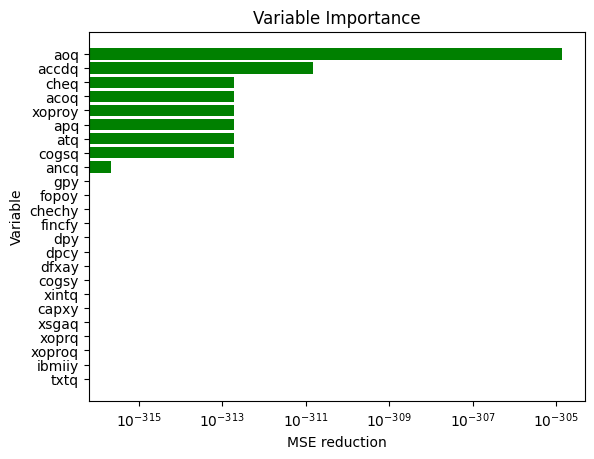

In [47]:
VarImpMean = VarImpResults.mean(axis=0)
VarImpMeanSorted = VarImpMean.sort_values(ascending=False)

variableDescriptions = pd.read_excel(
    "Data/CompustatVariableDescriptions/VariableDescriptions.xlsx", header=2)

VarImpMeanSorted = pd.merge(
    VarImpMeanSorted, variableDescriptions, left_on=[VarImpMeanSorted.columns], right_on="Variable Name")

pd.DataFrame.to_html(VarImpMeanSorted, "Results/VariableImportance.html", index=False)


VarImpMeanBest = VarImpMeanSorted[1:25]
# VarImpMeanScaled = VarImpMeanBest - VarImpMeanBest.mean()

import matplotlib.pyplot as plt

plt.barh(
    VarImpMeanBest.index, VarImpMeanBest, log=True, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)

plt.gca().invert_yaxis()  # labels read top-to-bottom


plt.title("Variable Importance")
plt.ylabel("Variable")
plt.xlabel("MSE reduction")
# plt.legend(['train', 'test'], loc='upper left')


plt.savefig("Results/VariableImportance7.png")
# from matplotlib.ticker import ScalarFormatter
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.show()


Epoch 1/300
676/676 - 4s - loss: 1987.6479 - mean_absolute_error: 20.3377 - val_loss: 2673.2761 - val_mean_absolute_error: 21.5853 - 4s/epoch - 5ms/step
Epoch 2/300
676/676 - 2s - loss: 1984.8063 - mean_absolute_error: 20.4015 - val_loss: 2667.5227 - val_mean_absolute_error: 21.5985 - 2s/epoch - 3ms/step
Epoch 3/300
676/676 - 3s - loss: 1982.5377 - mean_absolute_error: 20.4730 - val_loss: 2662.2070 - val_mean_absolute_error: 21.6164 - 3s/epoch - 4ms/step
Epoch 4/300
676/676 - 3s - loss: 1981.9677 - mean_absolute_error: 20.4623 - val_loss: 2662.0515 - val_mean_absolute_error: 21.6161 - 3s/epoch - 4ms/step
Epoch 5/300
676/676 - 2s - loss: 1979.8287 - mean_absolute_error: 20.4972 - val_loss: 2655.8665 - val_mean_absolute_error: 21.6415 - 2s/epoch - 4ms/step
Epoch 6/300
676/676 - 3s - loss: 1979.3455 - mean_absolute_error: 20.5257 - val_loss: 2657.9641 - val_mean_absolute_error: 21.6281 - 3s/epoch - 4ms/step
Epoch 7/300
676/676 - 2s - loss: 1978.1211 - mean_absolute_error: 20.5215 - val_lo

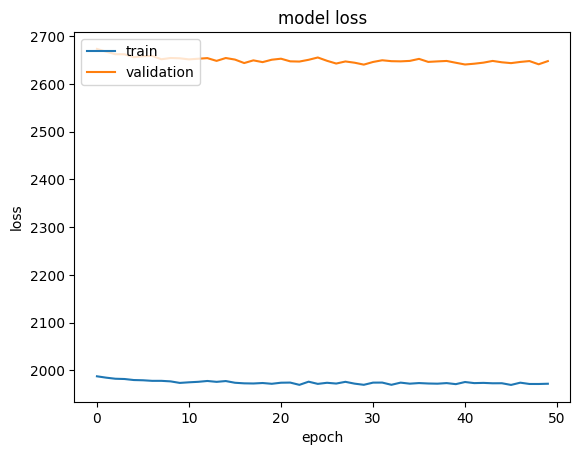

In [48]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


bestModel = keras.models.load_model('Results/BestKerasModel6')
#plot(model)


bestModel = tf.keras.Sequential()
bestModel.add(Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(Dense(units=1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)


bestModel.reset_states()


compiledBestModel = bestModel.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                                      loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                                      metrics=['MeanAbsoluteError'])

bestModel.reset_states()



#xTrainValiPooled = scaled_X[:validationSize,:]
xTrainValiPooled = X.loc[split=="Validation", :]
#yTrainValiPooled = Y[:validationSize]
yTrainValiPooled = Y[split=="Validation"]
history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32,
                        epochs=300, verbose=2, validation_data=(xWinTest, yTest), callbacks = [callback])


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Results/LearningCurve9.png')
plt.show()


# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()




In [49]:
#Visualize network

bestModel = keras.models.load_model('Results/BestKerasModel7')


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

import pydot
import pydotplus
import graphviz

from ann_visualizer.visualize import ann_viz

ann_viz(bestModel, view=True, filename="Results/BestModel7", title="Best Model Visualized")




In [50]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bestModel = keras.models.load_model('Results/BestKerasModel7')




#Print summary
modelSummary = bestModel.summary()
print(modelSummary)


with open('Results/BestModelSummary7.html', 'w') as f:

    bestModel.summary(print_fn=lambda x: f.write(x + '\n'))




# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import pydot
# import pydotplus
# import graphviz

# tf.keras.utils.plot_model(
#     bestModel,
#     to_file="Results/BestModel.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )



#pred = model.predict(xWinVal, batch_size=128)

#plt.scatter(pred, yVal)
#pred

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1)                 86        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




